In [1]:
import sys
import os
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

from quantizer import Quantizer
from lib.dataset_wrapper import Dataset
from lib import utils
from lib import abx_utils

In [35]:
ABX_NB_SAMPLES = 500
QUANTIZER_ABX_DISTANCES = [
    {
        "quantized_latent": {
            "metric": "cosine",
            "weight": 1,
        }
    },
]

In [27]:
quantizers_path = glob("../out/quantizer/*/")
quantizers_path = [q for q in quantizers_path if q.split('/')[-2] not in ['thomas', 'trash', 'Submission_CoLing']]
quantizers_path = [q for q in quantizers_path if q.split('/')[-2].split('_')[0] not in ['communicative', 'imitative']]
#quantizers_path = glob("../out/quantizer/thomas/*/")
#quantizers_path.sort()

In [28]:
quantizers_alias = {}

for quantizer_path in quantizers_path:
    quantizer = Quantizer.reload(quantizer_path, load_nn=False)
    config = quantizer.config
    
    quantizer_i = quantizer_path[-2]
    quantizer_alias = "\n".join((
         f"{','.join(config['dataset']['names'])}",
         f"hidden_layers={len(config['model']['hidden_dims'])}x{config['model']['hidden_dims'][0]}",
         f"{quantizer_i}",
     ))
    
    quantizers_alias[quantizer_alias] = quantizer_path

In [29]:
quantizers_abx_matrices = utils.pickle_load("../out/quantizer/abx_cache.pickle", {})

In [37]:
for quantizer_path in tqdm(quantizers_path):    
    if quantizer_path not in quantizers_abx_matrices:
        quantizers_abx_matrices[quantizer_path] = {}
    quantizer_abx_matrices = quantizers_abx_matrices[quantizer_path]
    
    for distance in QUANTIZER_ABX_DISTANCES:
        distance_signature = abx_utils.get_distance_signature(distance)
        if distance_signature not in quantizer_abx_matrices: 
            break
        else:
            continue
    
    quantizer = Quantizer.reload(quantizer_path)
    
    main_dataset = quantizer.main_dataset
    quantizer_lab = quantizer.get_datasplit_lab(2)
    quantizer_features = quantizer.autoencode_datasplit(2)
    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(quantizer_lab, consonants, vowels)
    
    for distance in QUANTIZER_ABX_DISTANCES:
        distance_signature = abx_utils.get_distance_signature(distance)
        #if distance_signature in quantizer_abx_matrices: continue
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, quantizer_features, distance, ABX_NB_SAMPLES)
        quantizer_abx_matrices[distance_signature] = abx_matrix
        utils.pickle_dump("../out/quantizer/abx_cache.pickle", quantizers_abx_matrices)


  0%|          | 0/10 [00:00<?, ?it/s]

tab:orange
tab:blue
tab:blue
tab:orange
tab:blue
tab:blue
tab:orange
tab:orange
tab:orange
tab:blue


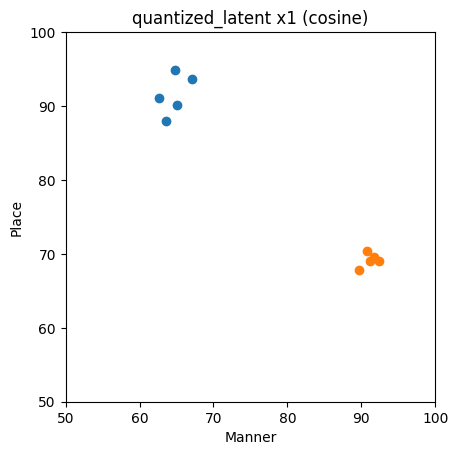

In [38]:
colors = {
    "cepstrum": "tab:orange",
    "art_params": "tab:blue",
    "cepstrum,art_params": "tab:green",
    "agent_art": "tab:pink",
}

for distance in QUANTIZER_ABX_DISTANCES:
    distance_signature = abx_utils.get_distance_signature(distance)
    
    plt.figure()
    ax = plt.subplot(aspect="equal")
    ax.set_xlim(50, 100)
    ax.set_ylim(50, 100)
    ax.set_xlabel("Manner")
    ax.set_ylabel("Place")
    
    ax.set_title(distance_signature)
    
    for quantizer_alias, quantizer_path in quantizers_alias.items():
        quantizer = Quantizer.reload(quantizer_path, load_nn=False)
        dataset = quantizer.main_dataset
        if ",".join(quantizer.config["dataset"]["names"]) != "pb2007":
            continue
        
        modalities = ",".join(quantizer.config["dataset"]["data_types"])
        if modalities.startswith("agent_art_"):
            color = colors["agent_art"]
        else:
            color = colors[modalities]
        print(color)
        consonants = dataset.phones_infos["consonants"]

        quantizer_abx_matrix = quantizers_abx_matrices[quantizer_path][distance_signature]
        quantizer_groups_score = abx_utils.get_groups_score(consonants, quantizer_abx_matrix, dataset.phones_infos["consonant_groups"])
        ax.scatter(quantizer_groups_score["manner"], quantizer_groups_score["place"], c=color)
        # raise
    
    plt.show()

In [39]:
art_abx_manner = []
art_abx_place = []
art_abx_global = []
cep_abx_manner = []
cep_abx_place = []
cep_abx_global = []
for quantizer_alias, quantizer_path in quantizers_alias.items():
    quantizer = Quantizer.reload(quantizer_path, load_nn=False)
    print(quantizer_path, quantizer.datasplits['pb2007'][2][:5])
    dataset = quantizer.main_dataset
    if ",".join(quantizer.config["dataset"]["names"]) != "pb2007":
        continue

    modality = ",".join(quantizer.config["dataset"]["data_types"])
    quantizer_abx_matrix = quantizers_abx_matrices[quantizer_path][distance_signature]
    groups_score = abx_utils.get_groups_score(consonants, quantizer_abx_matrix, dataset.phones_infos["consonant_groups"])
    global_score = abx_utils.get_global_score(quantizer_abx_matrix)
    if modality == 'cepstrum':
        cep_abx_manner.append(groups_score['manner'])
        cep_abx_place.append(groups_score['place'])
        cep_abx_global.append(global_score)
    elif modality == 'art_params':
        art_abx_manner.append(groups_score['manner'])
        art_abx_place.append(groups_score['place'])
        art_abx_global.append(global_score)
        
print("Gold cepstrum (quantized)")
print(f'N={len(cep_abx_global)}')
print('ABX place : mu=%.1f, std=%.1f' % (np.mean(cep_abx_place), np.std(cep_abx_place, ddof=1)))
print(f'ABX manner: mu=%.1f, std=%.1f' % (np.mean(cep_abx_manner), np.std(cep_abx_manner, ddof=1)))
print(f'ABX global: mu=%.1f, std=%.1f' % (np.mean(cep_abx_global), np.std(cep_abx_global, ddof=1)))
print("Gold art params (quantized)")
print(f'N={len(art_abx_global)}')
print('ABX place : mu=%.1f, std=%.1f' % (np.mean(art_abx_place), np.std(art_abx_place, ddof=1)))
print(f'ABX manner: mu=%.1f, std=%.1f' % (np.mean(art_abx_manner), np.std(art_abx_manner, ddof=1)))
print(f'ABX global: mu=%.1f, std=%.1f' % (np.mean(art_abx_global), np.std(art_abx_global, ddof=1)))

../out/quantizer/4be8cc80d3dee54979aded2bf85f175e-3/ ['item_0585', 'item_0828', 'item_0454', 'item_0118', 'item_0080']
../out/quantizer/5a62e02b1f4b948fc182f3ce77fe78b3-0/ ['item_0795', 'item_0523', 'item_0565', 'item_0240', 'item_1013']
../out/quantizer/5de8ab6795d0761e683c8b17b8ccb0ed-1/ ['item_0146', 'item_0799', 'item_0903', 'item_0740', 'item_1105']
../out/quantizer/e1bdb5d1cdf914f94952ada14d69cde5-1/ ['item_0146', 'item_0799', 'item_0903', 'item_0740', 'item_1105']
../out/quantizer/b59c32ccdc0f8e136e5c4f51163c7308-3/ ['item_0585', 'item_0828', 'item_0454', 'item_0118', 'item_0080']
../out/quantizer/3150462b1f57842881793e1f2ee97dd7-2/ ['item_0344', 'item_0119', 'item_1004', 'item_0133', 'item_0105']
../out/quantizer/f50650bb40e1346ed24011c2e41b7153-4/ ['item_0476', 'item_0461', 'item_0666', 'item_0385', 'item_0359']
../out/quantizer/a722eccbf1451d4931a277b2c721f64e-0/ ['item_0795', 'item_0523', 'item_0565', 'item_0240', 'item_1013']
../out/quantizer/ce8f3fdc5d22ccedbd090849107f699

In [54]:
distance = QUANTIZER_ABX_DISTANCES[0]
distance_signature = abx_utils.get_distance_signature(distance)

quantizers_loss = {
    "path": [],
    "datasets": [],
    "modalities": [],
    "hidden_layers": [],
    "num_embeddings": [],
    "embedding_dim": [],
    "dropout_p": [],
    "learning_rate": [],
    "commitment_cost": [],
    "total_loss": [],
    "reconstruction_error": [],
    "vq_loss": [],
    "abx_manner": [],
    "abx_place": [],
    "abx_global": [],
}

for quantizer_path in quantizers_path:
    quantizer = Quantizer.reload(quantizer_path, load_nn=False)
    config = quantizer.config
    
    with open("%s/metrics.pickle" % quantizer_path, "rb") as f:
        metrics = pickle.load(f)
    final_loss_index = np.argmin(metrics["validation"]["total_loss"])
    final_total_loss = metrics["test"]["total_loss"][final_loss_index]
    final_reconstruction_error = metrics["test"]["reconstruction_error"][final_loss_index]
    final_vq_loss = metrics["test"]["vq_loss"][final_loss_index]
    
    quantizers_loss["path"].append(quantizer_path)
    quantizers_loss["datasets"].append(",".join(config['dataset']['names']))
    quantizers_loss["modalities"].append(",".join(config['dataset']['data_types']))
    quantizers_loss["hidden_layers"].append(f"{len(config['model']['hidden_dims'])}x{config['model']['hidden_dims'][0]}")
    quantizers_loss["num_embeddings"].append(config['model']['num_embeddings'])
    quantizers_loss["embedding_dim"].append(config['model']['embedding_dim'])
    quantizers_loss["dropout_p"].append(config['model']['dropout_p'])    
    quantizers_loss["learning_rate"].append(config['training']['learning_rate'])
    quantizers_loss["commitment_cost"].append(config['model']['commitment_cost'])
    
    quantizers_loss["total_loss"].append(final_total_loss)
    quantizers_loss["reconstruction_error"].append(final_reconstruction_error)
    quantizers_loss["vq_loss"].append(final_vq_loss)
    
    dataset = quantizer.main_dataset
    consonants = quantizer.main_dataset.phones_infos["consonants"]
    vowels = quantizer.main_dataset.phones_infos["vowels"]
    quantizer_abx_matrix = quantizers_abx_matrices[quantizer_path][distance_signature]
    quantizer_groups_score = abx_utils.get_groups_score(consonants, quantizer_abx_matrix, dataset.phones_infos["consonant_groups"])
    quantizer_global_score = abx_utils.get_global_score(quantizer_abx_matrix)
    
    quantizers_loss["abx_manner"].append(quantizer_groups_score["manner"])
    quantizers_loss["abx_place"].append(quantizer_groups_score["place"])
    quantizers_loss["abx_global"].append(quantizer_global_score)
    
quantizers_loss = pd.DataFrame(quantizers_loss)

/home/engaclew/agent/lib/abx_utils.py:140: RuntimeWarning: invalid value encountered in long_scalars
  subgroup_score = subgroup_nb_success / subgroup_nb_test
/home/engaclew/agent/lib/abx_utils.py:120: RuntimeWarning: invalid value encountered in long_scalars
  return abx_matrix[0].sum() / abx_matrix[1].sum() * 100


In [55]:
datasets = pd.unique(quantizers_loss["datasets"])
modalities = pd.unique(quantizers_loss["modalities"])

def show_top_quantizers(measure="abx_global", datasets=datasets[0], modalities=modalities[0], ascending=False):
    subset = quantizers_loss[quantizers_loss["datasets"] == datasets]
    subset = subset[subset["modalities"] == modalities]
    display(subset.sort_values(measure, ascending=ascending).head(30))

ipw.interactive(show_top_quantizers, measure=quantizers_loss, datasets=datasets, modalities=modalities, ascending=False)

interactive(children=(Dropdown(description='measure', index=14, options=('path', 'datasets', 'modalities', 'hi…

In [53]:
quantizers_loss.loc[25]

path                    ../out/quantizer/c7502a9c6785e296b8076f4ddf64e...
datasets                                                           pb2007
modalities                                                     art_params
hidden_layers                                                       3x256
num_embeddings                                                        512
embedding_dim                                                          64
dropout_p                                                            0.32
learning_rate                                                       0.002
commitment_cost                                                      1.08
total_loss                                                        0.20606
reconstruction_error                                             0.148223
vq_loss                                                          0.057837
abx_manner                                                           67.3
abx_place                             